# The  Research  Space

"Here we use a large dataset of scholarly publications disambiguated at the individual level to create a map of science — or research  space — where links connect pairs of fields based on the probability that an individual has published in both of them."
[Original Article](https://arxiv.org/ftp/arxiv/papers/1602/1602.08409.pdf)

[Artigo suplementar](https://link.springer.com/content/pdf/10.1140/epjds/s13688-019-0210-z.pdf)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from collections import Counter
import geopandas as gpd
import networkx as nx
import pandas as pd
import numpy as np
import unidecode
import re

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Our data

Primeiramente, as categorias e áreas

In [13]:
areas = pd.read_pickle("../dataset/SJR/areas.pkl")
areas.head()

,Code,Field,Subject area,Classification
0,1000.0,multidisciplinary,health sciences,multidisciplinary
1,1100.0,general agricultural and biological sciences,life sciences,agricultural and biological sciences
2,1101.0,agricultural and biological sciences (miscella...,life sciences,agricultural and biological sciences
3,1102.0,agronomy and crop science,life sciences,agricultural and biological sciences
4,1103.0,animal science and zoology,life sciences,agricultural and biological sciences


Instituição do pesquisador para agregar os dados (tratando as strings para as diferentes formas de escrever o nome)

In [6]:
def ops(s):
    s = re.sub(r"\s?\(.*\)", "", s)
    s = unidecode.unidecode(s)
    s = s.lower()
    s = re.sub(",", " ", s)
    s = re.sub("\.", " ", s)
    s = re.sub(";", " ", s)
    s = re.sub("\s+", " ", s)
    s = s.strip()
    
    return s

In [7]:
bio = pd.read_csv("../dataset/lattes/pesquisadores.csv", sep=";sep;", engine="python").dropna(subset=['id_pesquisador'])
bio = bio[bio["id_pesquisador"] != "None"]
bio = bio.fillna("none")
bio["nome_instituicao"] = bio["nome_instituicao"].astype(str).apply(lambda x: ops(x))
bio["cep_instituicao"] = bio["cep_instituicao"].astype(str).apply(lambda x: re.sub("\-", "", x))
bio.head()

,id_pesquisador,nome_instituicao,cep_instituicao
0,0099900328713566,universidade federal do oeste da bahia,47808021
1,0026846500140475,instituto federal de educacao ciencia e tecnol...,49032490
2,0084190106475603,universidade federal do rio de janeiro,21945970
3,0027688823067577,instituto federal de educacao ciencia e tecnol...,45320000
4,0017466571949740,ministerio publico do estado do rio de janeiro,20020080


Por fim, lendo os dados feitos pelo research space

In [8]:
k = np.load("../dataset/phi_matrix_2011.npy")
x = np.load("../dataset/x_dict_2011.npy", allow_pickle='TRUE').item()

of = list()
with open("../dataset/of_2011.txt", "r") as f:
    for item in f:
        of.append(item.strip())

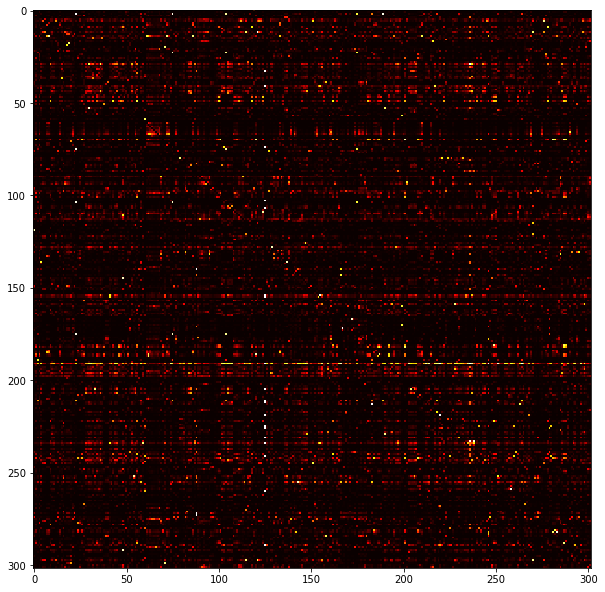

In [10]:
plt.rcParams["figure.figsize"] = (10,50)
plt.imshow(k, cmap='hot', interpolation='nearest')
plt.show()

### Graph Plot

Get colors

In [53]:
def get_colors(vals):
    if any(isinstance(x, float) for x in vals):
        cm = plt.get_cmap('hot')
    else:    
        cm = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=max(vals))
    scalar_map = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
    return [cm, scalar_map]

Get node size

In [14]:
def get_node_size():
    values = [40 for node in of]
    values[of.index("computer science applications")] = 300    
    return values

Plot function

In [87]:
def show_graph(A, values, pos=None, labels=None, threshold=0.212):
    plt.rcParams["figure.figsize"] = (15,10)
    G = nx.from_numpy_matrix(A)
    mast = nx.maximum_spanning_tree(G)
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i != j:
                if A[i,j] > threshold:
                    mast.add_edge(i,j)
   
    
    f = plt.figure(1)
    ax = f.add_subplot(1,1,1)

    if pos == None: pos = nx.spring_layout(mast)

    cm, scalarMap = get_colors(values)
    
    if labels != None:
        for lab in labels:
            ax.plot([0],[0], color = scalarMap.to_rgba(labels[lab]), label=lab, lw=7)
        plt.legend(loc='upper left')

    nx.draw_networkx(mast, pos, cmap=cm, vmin=0, vmax= max(values), node_color=values, with_labels=False,
                     ax=ax, node_size=get_node_size(), edge_size=1, edge_color="lightgray")
                                                                                                            
    plt.axis('off')
    f.set_facecolor('w')
    plt.show()
    
    return pos

Using macro subjects

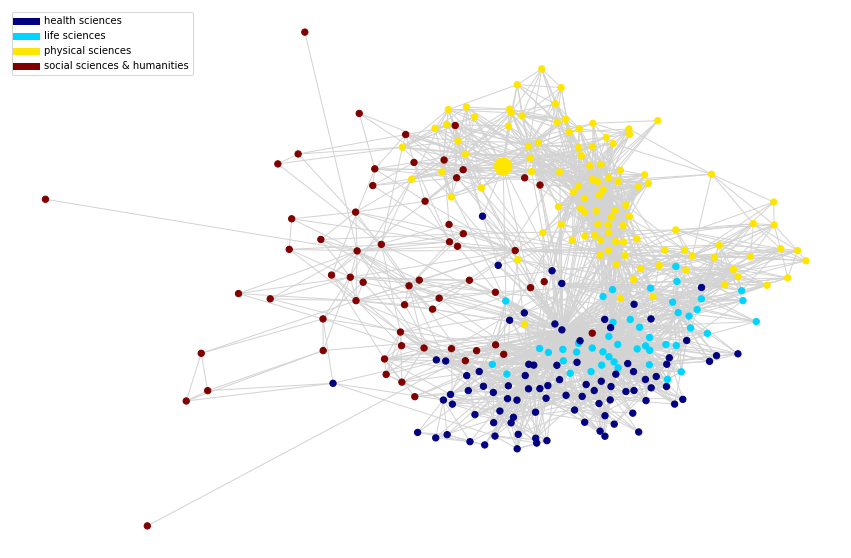

In [96]:
dict_area = areas[["Field", "Subject area"]].set_index("Field").to_dict()["Subject area"]
unique = areas["Subject area"].unique()
subs = {u: v for v,u in enumerate(sorted(unique))}
values = [subs[dict_area[node]] for node in of]

pos = show_graph(k, values, labels=subs)

Podemos variar o valor do threshold para melhor visualizar

In [97]:
def f(th):
    show_graph(k, values, pos, subs, th)

interact(f, th=(0.05,0.95,0.05))

interactive(children=(FloatSlider(value=0.45, description='th', max=0.95, min=0.05, step=0.05), Output()), _do…

<function __main__.f(th)>

Using intermediate classification

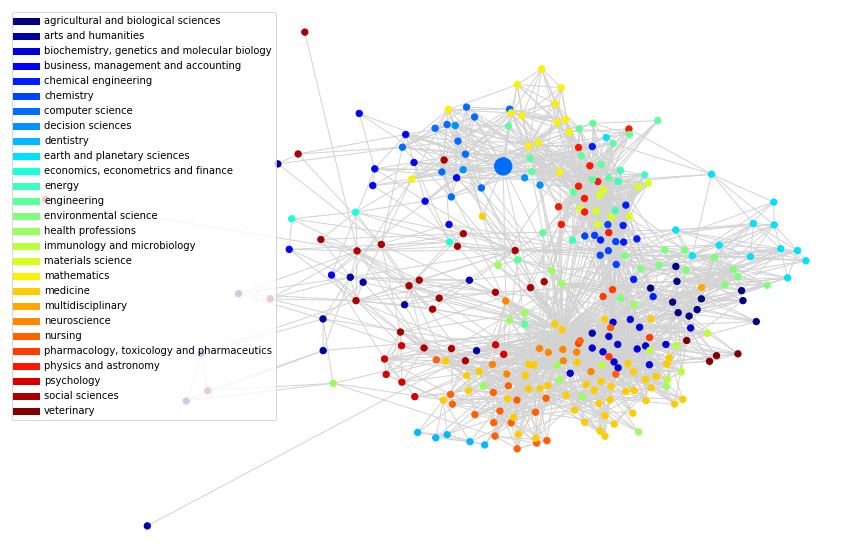

In [98]:
dict_area = areas[["Field", "Classification"]].set_index("Field").to_dict()["Classification"]
unique = areas["Classification"].unique()
subs = {u: v for v,u in enumerate(sorted(unique))}
values = [subs[dict_area[node]] for node in of]

pos = show_graph(k, values, pos, subs)

### Revealed Comparative Advantage

"We next use the research space to predict the future presence of an individual, organization, or country in a research field. To make these predictions we define five possible states for individuals, organizations, or countries in a research field. These states are: inactive, active, nascent, intermediate, and developed."

In [99]:
rca = dict()
sum_f = dict()
sum_s = dict()
sum_sf = 0

for sf in x:
    if sf[0] in sum_f:
        sum_f[sf[0]] += x[sf]
    else:
        sum_f[sf[0]] = x[sf]

    if sf[1] in sum_s:   
        sum_s[sf[1]] += x[sf]
    else:
        sum_s[sf[1]] = x[sf]
    
    sum_sf += x[sf]

    
for sf in x:
    rca[sf] = (x[sf]/sum_f[sf[0]])/(sum_s[sf[1]]/sum_sf)

Também podemos computar o RCA de instituições

In [100]:
inst = bio[["id_pesquisador", "nome_instituicao"]].set_index("id_pesquisador").to_dict()["nome_instituicao"]
inst = {int(k): v for k, v in inst.items()}

x_inst = dict()
rca_inst = dict()
sum_f_inst = dict()

for sf in x:
    ins = inst[sf[0]]
    if (ins, sf[1]) in x_inst:
        x_inst[(ins, sf[1])] += x[sf]
    else:
        x_inst[(ins, sf[1])] = x[sf]
    
    if ins in sum_f_inst:
        sum_f_inst[ins] += x[sf]
    else:
        sum_f_inst[ins] = x[sf]

    
for sf in x_inst:
    rca_inst[sf] = (x_inst[sf]/sum_f_inst[sf[0]])/(sum_s[sf[1]]/sum_sf)

e de municípios/estados/regiões

In [101]:
def cep_estado(n):
    n = str(n)[:5]
    
    if not all(c.isdigit() for c in n) or n == '':
        return "DESCONHECIDO"
    
    n = int(n)
    if n < 20000: return "35"
    if n < 29000: return "33"
    if n < 30000: return "32"
    if n < 40000: return "31"
    if n < 49000: return "29"
    if n < 50000: return "28"
    if n < 57000: return "26"
    if n < 58000: return "27"
    if n < 59000: return "25"
    if n < 60000: return "24"  
    if n < 64000: return "23"
    if n < 65000: return "22"
    if n < 66000: return "21"
    if n < 68900: return "15"
    if n < 69000: return "16"
    if n < 69300: return "13"
    if n < 69400: return "14"
    if n < 69500: return "12"
    if n < 70000: return "13"
    if n < 73700: return "53"
    if n < 76800: return "52"
    if n < 77000: return "14"
    if n < 78000: return "17"
    if n < 79000: return "51"
    if n < 80000: return "50"
    if n < 88000: return "41"
    if n < 90000: return "42"
    if n < 100000: return "43"

In [102]:
id_cep = bio[["id_pesquisador", "cep_instituicao"]].set_index("id_pesquisador").to_dict()["cep_instituicao"]
id_estado = {int(k): cep_estado(v) for k, v in id_cep.items()}

x_est = dict()
rca_est = dict()
sum_f_est = dict()

for sf in x:
    est = id_estado[sf[0]]
    if (est, sf[1]) in x_est:
        x_est[(est, sf[1])] += x[sf]
    else:
        x_est[(est, sf[1])] = x[sf]
    
    if est in sum_f_est:
        sum_f_est[est] += x[sf]
    else:
        sum_f_est[est] = x[sf]

    
for sf in x_est:
    rca_est[sf] = (x_est[sf]/sum_f_est[sf[0]])/(sum_s[sf[1]]/sum_sf)

In [103]:
nome_cep = bio[["nome_instituicao", "cep_instituicao"]].set_index("nome_instituicao").to_dict()["cep_instituicao"]
nome_estado = sorted([k for k, v in nome_cep.items() if cep_estado(v) == "DESCONHECIDO"])
nome_estado[1010:1020]

['universidade de portsmouth',
 'universidade de quebec',
 'universidade de quebec em montreal',
 'universidade de santiago',
 'universidade de sao paulo usp',
 'universidade de sydney',
 'universidade de ulm',
 'universidade de varsovia',
 'universidade de verona',
 'universidade de vigo']

### Visualizando o RCA

Áreas de maior atuação de diferentes instituições do país. Mediremos a fração de áreas de cada categoria que uma instituição tem RCA > 1.

In [104]:
dict_area = areas[["Field", "Classification"]].set_index("Field").to_dict()["Classification"]
size = Counter(areas["Classification"].tolist())
macro = dict()

for sf in rca_inst:
    if rca_inst[sf] > 1:
        if (sf[0], dict_area[sf[1]]) in macro:
            macro[(sf[0], dict_area[sf[1]])] += 1 / size[dict_area[sf[1]]]
        else:
            macro[(sf[0], dict_area[sf[1]])] = 1 / size[dict_area[sf[1]]] 

In [105]:
insts = [
    "universidade federal de minas gerais",
    "universidade federal de lavras",
    "universidade de sao paulo",
    "universidade estadual de campinas",
    "universidade federal da paraiba",
    "universidade federal rural de pernambuco",
    "universidade federal do rio de janeiro",
    "pontificia universidade catolica de minas gerais",
    "petrobras",
    "ministerio da fazenda"
]

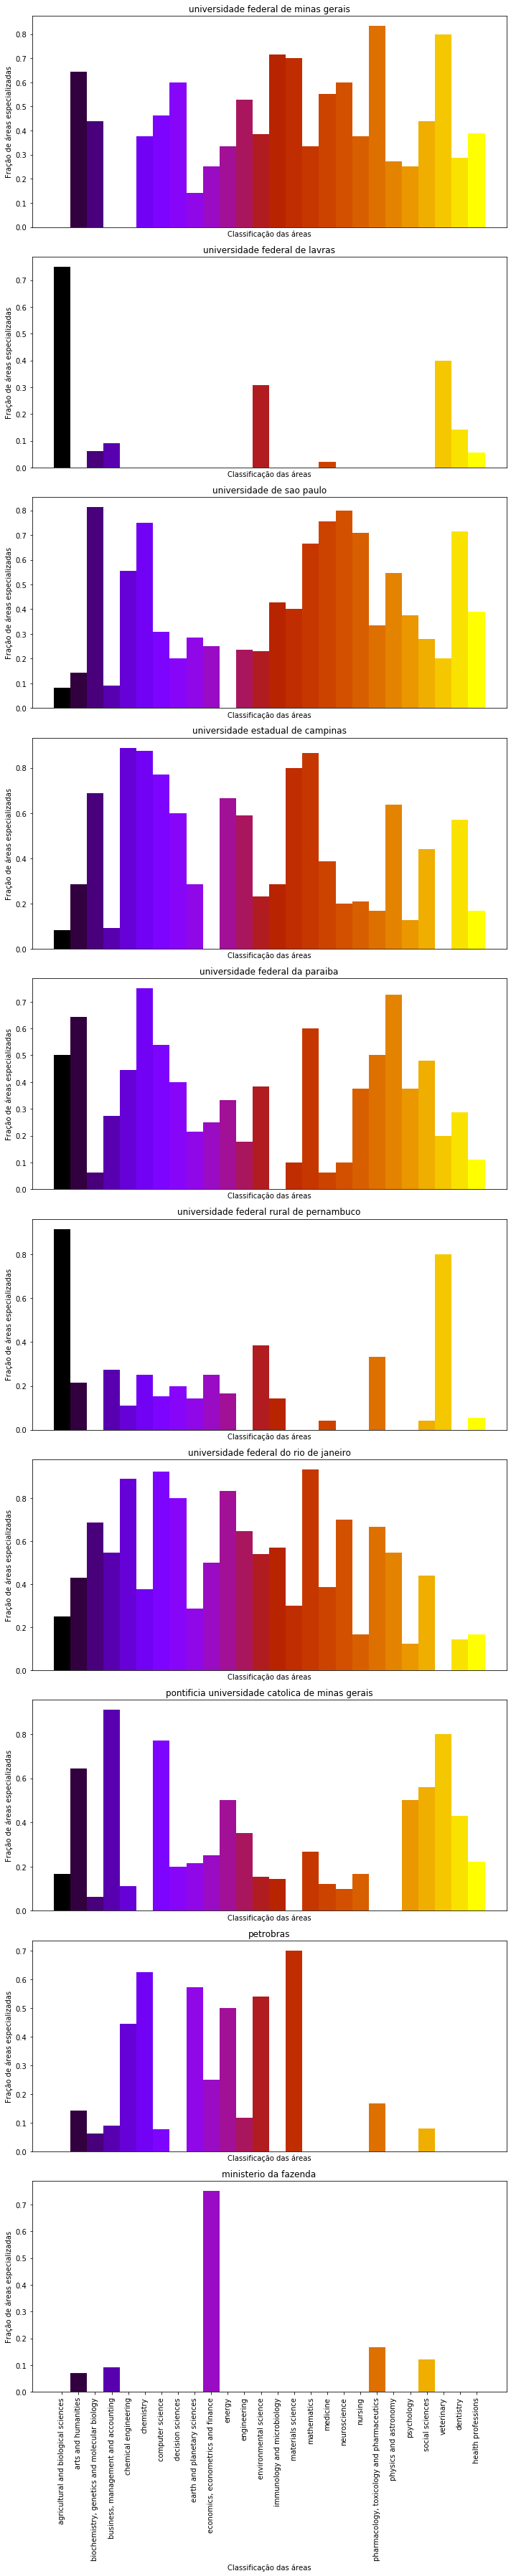

In [106]:
unique = areas["Classification"].unique()[1:]

plt.rcParams["figure.figsize"] = (10,50)
cm = cmx.get_cmap('gnuplot', 26)
color = cm(np.linspace(0, 1, 26))
fig = plt.figure()

for i in range(len(insts)):
    uni = insts[i]
    areas_list = list()
    for a in unique:
        if (uni, a) in macro:
            areas_list.append(macro[(uni, a)])
        else:
            areas_list.append(0)

    sub = fig.add_subplot(10,1,i+1)
    plt.bar(unique, areas_list, color=color, width=1.0)
    plt.xticks(rotation=90)
    plt.title(uni)
    plt.ylabel("Fração de áreas especializadas")
    plt.xlabel("Classificação das áreas")
    if i < 9:
        sub.set_xticks([])
    
fig.tight_layout()
plt.show()

Podemos também ver a rede do Research Space colorida pelos RCA dessas instituições

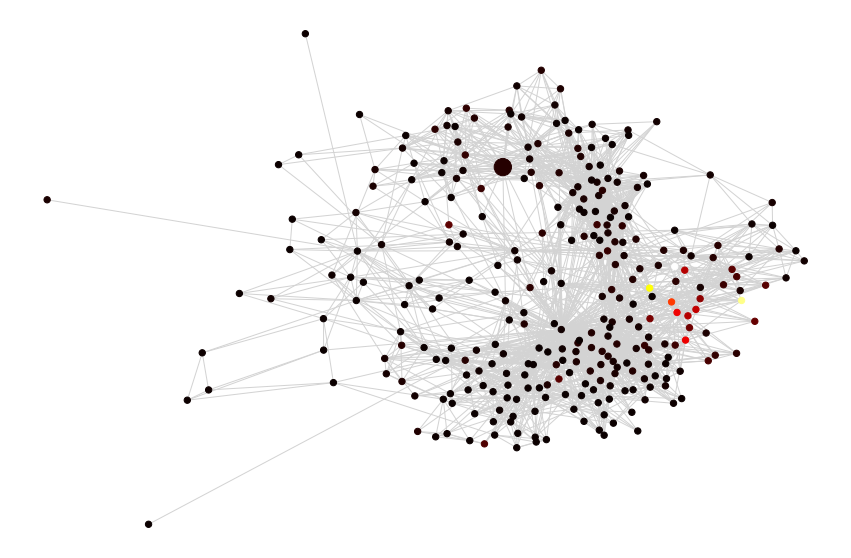

In [107]:
uni = "universidade federal de lavras"
vals = list()
for f in of:
    if (uni, f) in rca_inst:
        vals.append(rca_inst[(uni, f)])
    else:
        vals.append(0)

pos = show_graph(k, vals, pos)

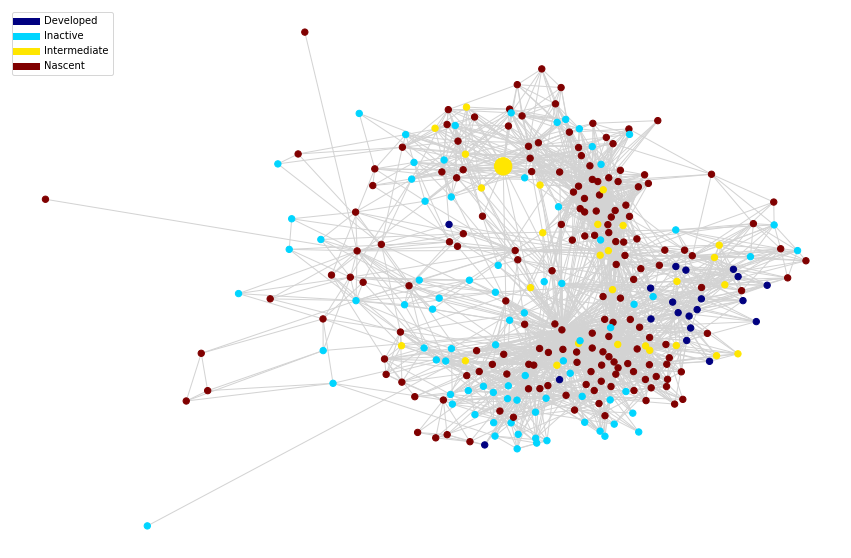

In [108]:
def rca_disc(val):
    if val == 0:
        return "Inactive"
    if val < 0.5:
        return "Nascent"
    if val < 1:
        return "Intermediate"
    else:
        return "Developed"

dict_area = {of[x]:rca_disc(vals[x]) for x in range(len(of))}
unique = ["Inactive", "Nascent", "Intermediate", "Developed"]
subs = {u: v for v,u in enumerate(sorted(unique))}
values = [subs[dict_area[node]] for node in of]

pos = show_graph(k, values, pos, subs)

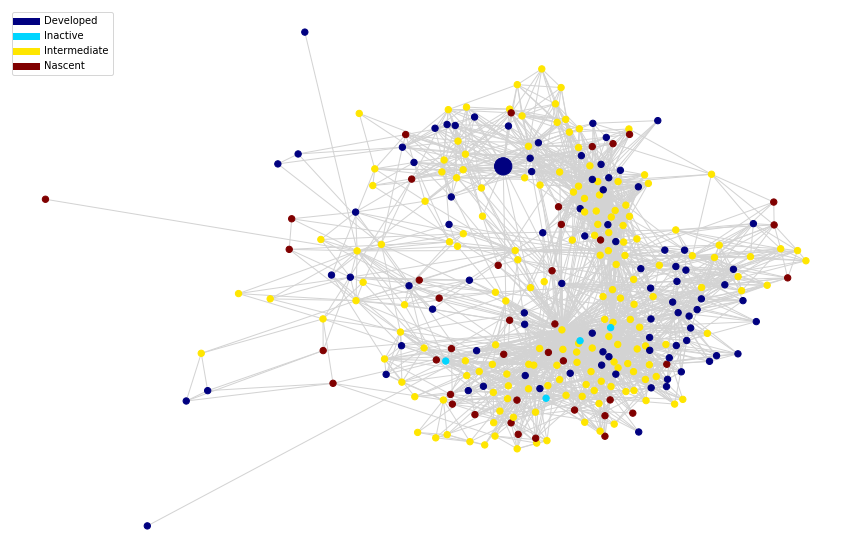

In [109]:
estado = "31"
vals = list()
for f in of:
    if (estado, f) in rca_est:
        vals.append(rca_est[(estado, f)])
    else:
        vals.append(0)

def rca_disc(val):
    if val == 0:
        return "Inactive"
    if val < 0.5:
        return "Nascent"
    if val < 1:
        return "Intermediate"
    else:
        return "Developed"

dict_area = {of[x]:rca_disc(vals[x]) for x in range(len(of))}
unique = ["Inactive", "Nascent", "Intermediate", "Developed"]
subs = {u: v for v,u in enumerate(sorted(unique))}
values = [subs[dict_area[node]] for node in of]

pos = show_graph(k, values, pos, subs)

In [110]:
gdf = gpd.read_file("../dataset/br_unidades_da_federacao/BRUFE250GC_SIR.shp")
gdf.head()

,NM_ESTADO,NM_REGIAO,CD_GEOCUF,geometry
0,ACRE,NORTE,12,"POLYGON ((-73.18253 -7.33550, -73.05413 -7.381..."
1,ALAGOAS,NORDESTE,27,"POLYGON ((-35.46753 -8.81744, -35.46659 -8.817..."
2,AMAPÁ,NORTE,16,"MULTIPOLYGON (((-50.18123 1.90099, -50.17688 1..."
3,AMAZONAS,NORTE,13,"POLYGON ((-67.32609 2.02971, -67.31682 2.00125..."
4,BAHIA,NORDESTE,29,"MULTIPOLYGON (((-38.65484 -18.04242, -38.65819..."


In [111]:
dict_area = areas[["Field", "Classification"]].set_index("Field").to_dict()["Classification"]
size = Counter(areas["Classification"].tolist())
macro = dict()

for sf in rca_est:
    if rca_est[sf] > 1:
        if (sf[0], dict_area[sf[1]]) in macro:
            macro[(sf[0], dict_area[sf[1]])] += 1 / size[dict_area[sf[1]]]
        else:
            macro[(sf[0], dict_area[sf[1]])] = 1 / size[dict_area[sf[1]]] 

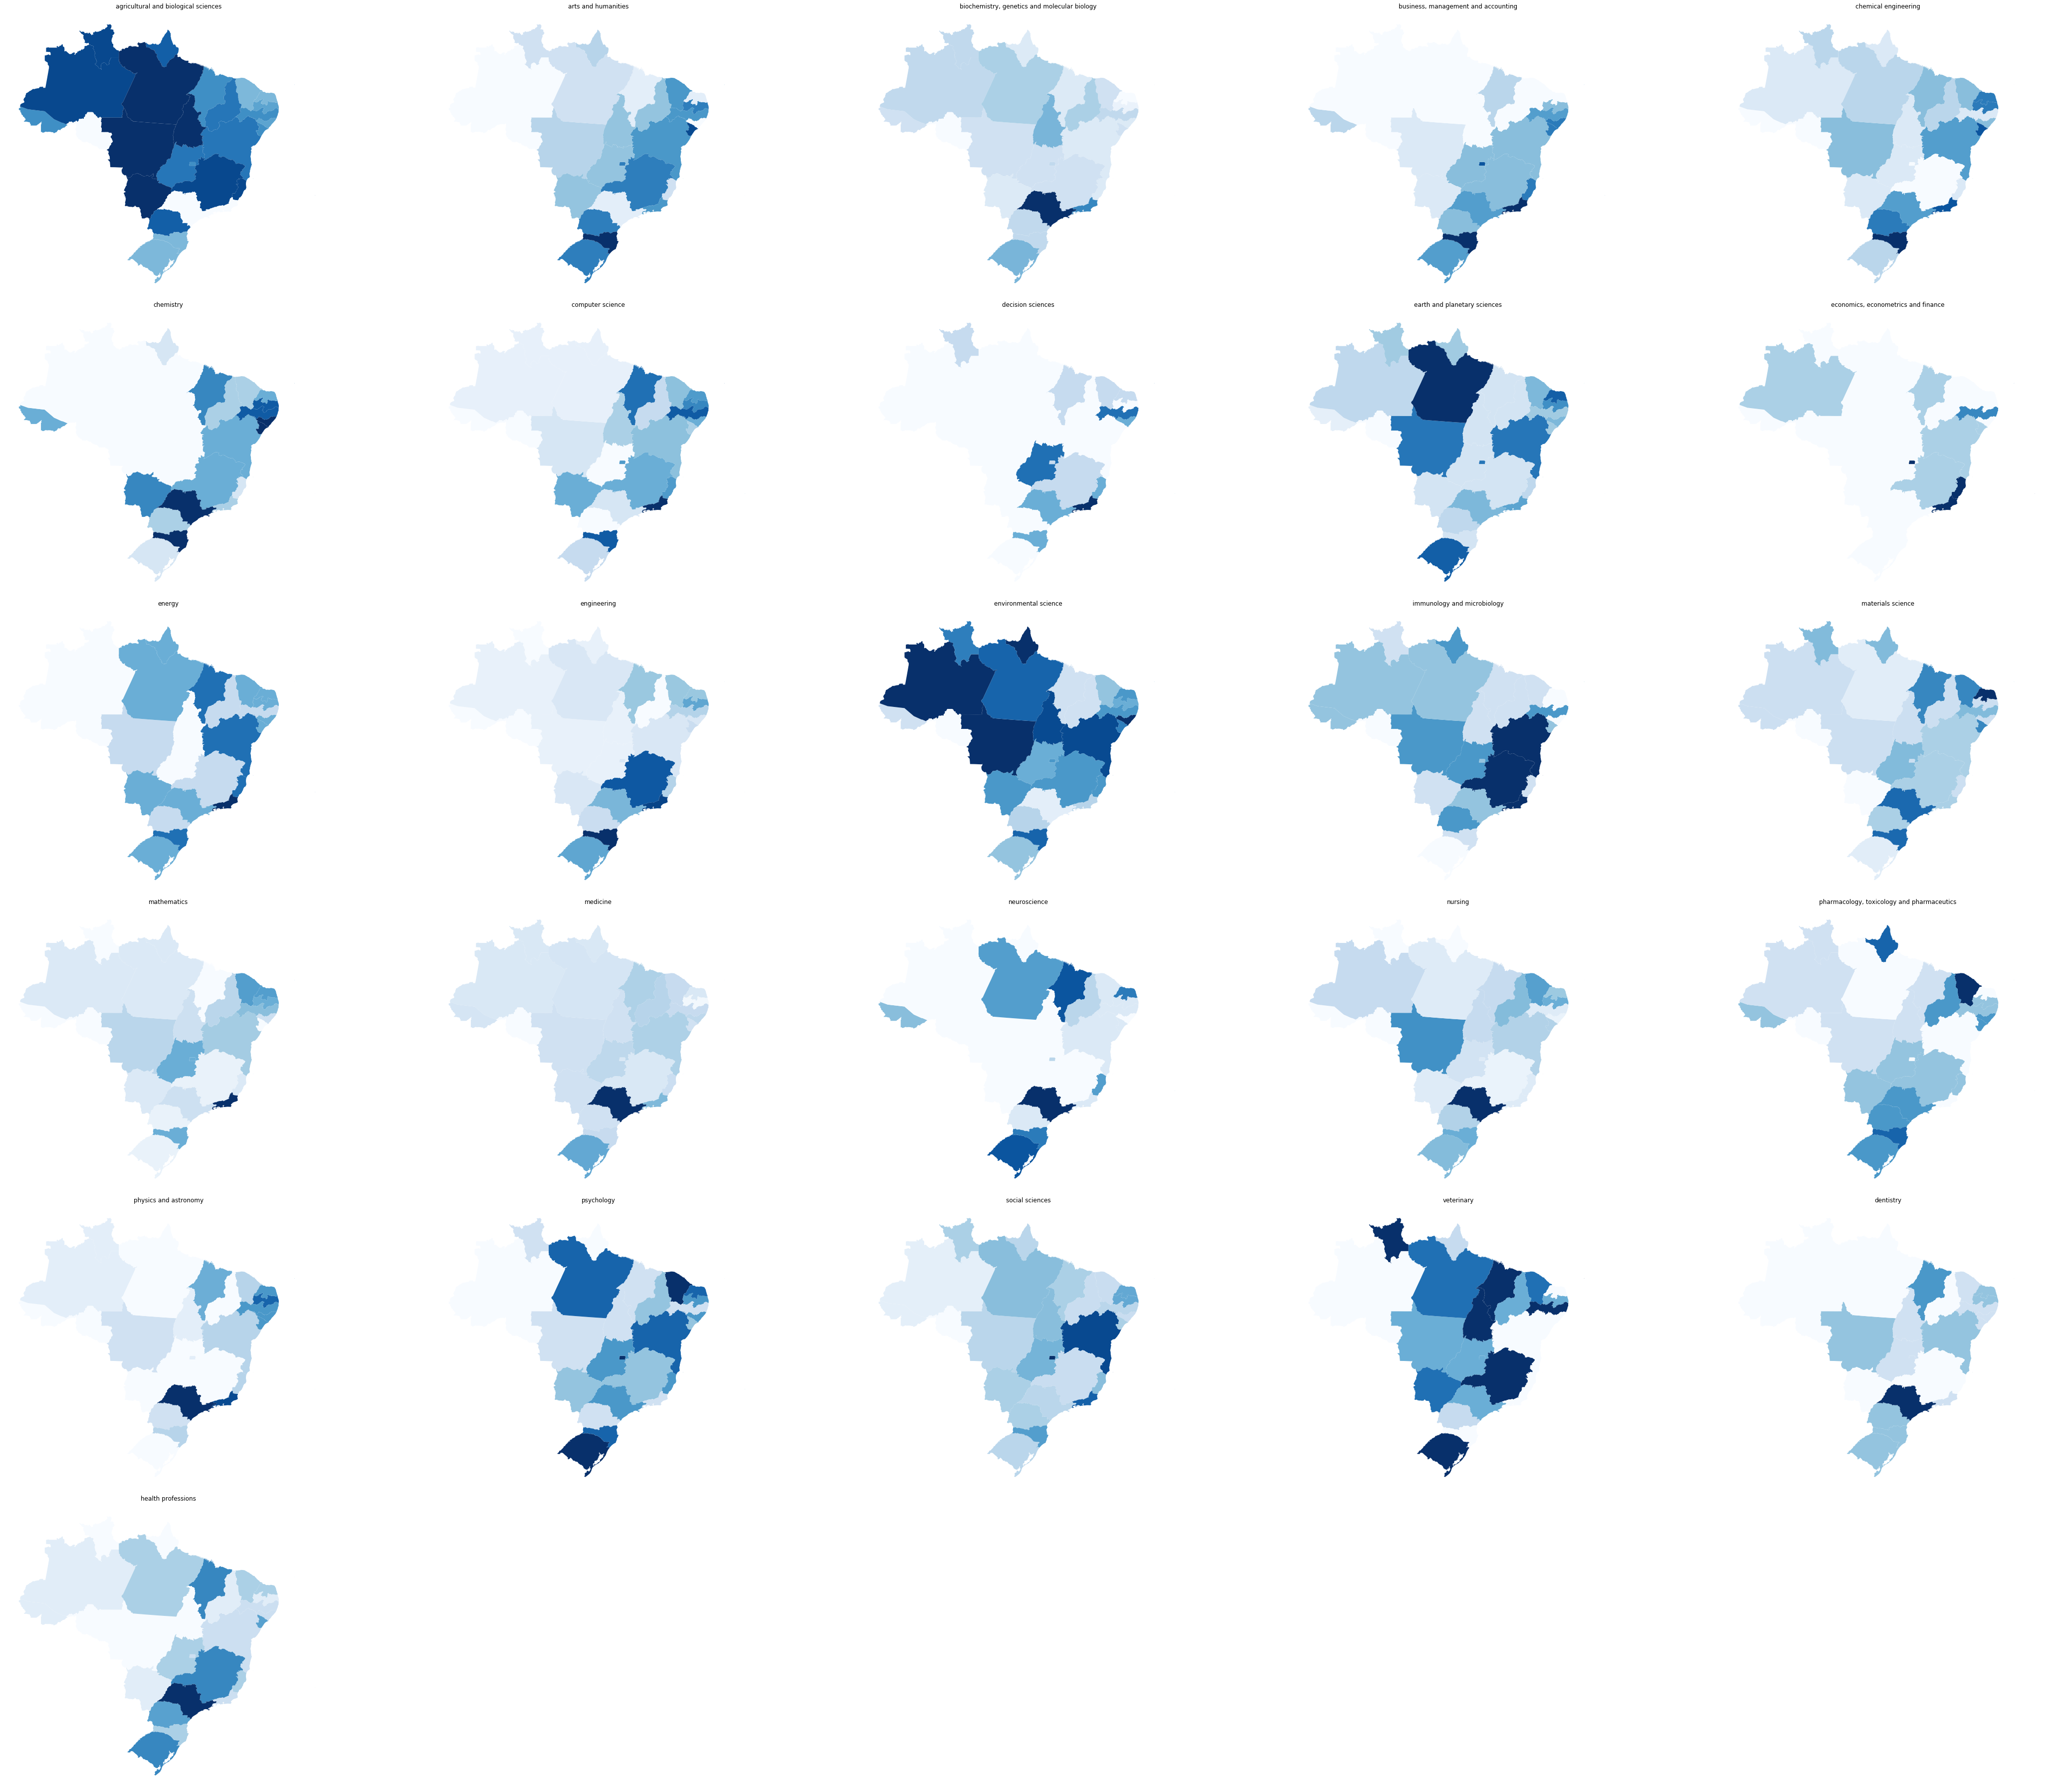

In [112]:
unique = areas["Classification"].unique()[1:]
estados = gdf["CD_GEOCUF"].to_list()

plt.rcParams["figure.figsize"] = (60,50)
fig = plt.figure()

for i in range(len(unique)):
    a = unique[i]
    estados_list = list()
    for est in estados:
        if (est, a) in macro:
            estados_list.append(macro[(est, a)])
        else:
            estados_list.append(0)

    gdf["colors"] = estados_list
    ax = fig.add_subplot(6,5,i+1)
    ax.axis('off')
    gdf.plot(column="colors", ax=ax, cmap='Blues')
    plt.title(a)
    
fig.tight_layout()
plt.show()

Áreas urbanas

"First, we infer the country in which each affiliation-city pair is located; second, for each country, we compute a geographic distance matrix (using Vicenty’s formula) connecting each pair of cities; and lastly we use hierarchical clustering to define the different urban areas with the additional constraint that the maximum distance within each cluster has to be less than 50 km."

### Prediction

"We then predict the probability that individual, organization, or country, $s$ will increase its level of development in field $f$ by creating an indicator of the fraction of fields that are connected to field $f$ and that are already  developed by $s$"

### Correlation

Correlation analysis between the average knowledge density aggregated at the state/municipal level and a selection of development indicators